<a href="https://colab.research.google.com/github/Embeddedkuba/wakewords/blob/main/tensorflow_01_speech_commands_mfcc_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from os import listdir
from os.path import isdir, join
import librosa
import random
import numpy as np
import matplotlib.pyplot as plt
!pip install python_speech_features
import python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp37-none-any.whl size=5887 sha256=ef1bb8122a32c299d89f0f7bb8ae572443bf9c41627466b4d5f6a86427fcd679
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
# Dataset path and view possible targets
dataset_path = '/content/drive/MyDrive/datasets'
for name in listdir(dataset_path):
    if isdir(join(dataset_path, name)):
        print(name)

PawnToA2
PawnToA3
PawnToA1


In [24]:
# Create an all targets list
all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
print(all_targets)

['PawnToA2', 'PawnToA3', 'PawnToA1']


In [6]:
# Leave off background noise set
all_targets.remove('_background_noise_')
print(all_targets)

ValueError: ignored

In [25]:
# See how many files are in each
num_samples = 0
for target in all_targets:
    print(len(listdir(join(dataset_path, target))))
    num_samples += len(listdir(join(dataset_path, target)))
print('Total samples:', num_samples)

50
50
50
Total samples: 150


In [26]:
# Settings
target_list = all_targets
feature_sets_file = 'all_targets_mfcc_sets.npz'
perc_keep_samples = 0.9 # 1.0 is keep all samples
val_ratio = 0.2
test_ratio = 0.2
sample_rate = 8000
num_mfcc = 16
len_mfcc = 16


In [27]:
# Create list of filenames along with ground truth vector (y)
filenames = []
y = []
for index, target in enumerate(target_list):
    print(join(dataset_path, target))
    filenames.append(listdir(join(dataset_path, target)))
    y.append(np.ones(len(filenames[index])) * index)

/content/drive/MyDrive/datasets/PawnToA2
/content/drive/MyDrive/datasets/PawnToA3
/content/drive/MyDrive/datasets/PawnToA1


In [28]:
# Check ground truth Y vector
print(y)
for item in y:
    print(len(item))

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])]
50
50
50


In [29]:
# Flatten filename and y vectors
filenames = [item for sublist in filenames for item in sublist]
y = [item for sublist in y for item in sublist]

In [32]:
# Associate filenames with true output and shuffle
filenames_y = list(zip(filenames, y))
random.shuffle(filenames_y)
filenames, y = zip(*filenames_y)

In [31]:
# Only keep the specified number of samples (shorter extraction/training)
print(len(filenames))
filenames = filenames[:int(len(filenames) * perc_keep_samples)]
print(len(filenames))

150
135


In [33]:
# Calculate validation and test set sizes
val_set_size = int(len(filenames) * val_ratio)
test_set_size = int(len(filenames) * test_ratio)

In [34]:
# Break dataset apart into train, validation, and test sets
filenames_val = filenames[:val_set_size]
filenames_test = filenames[val_set_size:(val_set_size + test_set_size)]
filenames_train = filenames[(val_set_size + test_set_size):]


In [35]:
# Break y apart into train, validation, and test sets
y_orig_val = y[:val_set_size]
y_orig_test = y[val_set_size:(val_set_size + test_set_size)]
y_orig_train = y[(val_set_size + test_set_size):]

In [36]:
# Function: Create MFCC from given path
def calc_mfcc(path):
    
    # Load wavefile
    signal, fs = librosa.load(path, sr=sample_rate)
    
    # Create MFCCs from sound clip
    mfccs = python_speech_features.base.mfcc(signal, 
                                            samplerate=fs,
                                            winlen=0.256,
                                            winstep=0.150,
                                            numcep=num_mfcc,
                                            nfilt=26,
                                            nfft=2048,
                                            preemph=0.0,
                                            ceplifter=0,
                                            appendEnergy=False,
                                            winfunc=np.hanning)
    return mfccs.transpose()

In [37]:

# TEST: Construct test set by computing MFCC of each WAV file
prob_cnt = 0
x_test = []
y_test = []
for index, filename in enumerate(filenames_train):
    
    # Stop after 500
    if index >= 500:
        break
    
    # Create path from given filename and target item
    path = join(dataset_path, target_list[int(y_orig_train[index])], 
                filename)
    
    # Create MFCCs
    mfccs = calc_mfcc(path)
    
    if mfccs.shape[1] <= len_mfcc+1000: #why equal!?
        x_test.append(mfccs)
        y_test.append(y_orig_train[index])
    else:
        print('Dropped:', index, mfccs.shape)
        prob_cnt += 1
        

In [38]:
print('% of problematic samples:', prob_cnt / 500)

% of problematic samples: 0.0


MFCCs: [[-4.40240492e+01 -3.89570141e+01 -3.64043416e+01 -3.66937446e+01
  -4.53951886e+01 -4.46403038e+01]
 [ 1.28954936e+01  4.03080507e+00  9.86395610e+00  4.44873020e+00
   1.15935010e+01  1.09468376e+01]
 [-8.28500808e-01 -5.87088950e-01 -3.82017177e+00 -2.21518950e+00
  -4.53616328e+00 -4.77513801e+00]
 [-1.44436299e+01 -4.81848451e+00 -3.92798853e+00 -4.71502153e+00
  -8.88544548e+00 -7.90028711e+00]
 [-6.54220923e+00 -3.55945351e+00 -6.17229544e+00 -1.33491799e+01
  -9.65994637e+00 -4.31206605e+00]
 [-4.63506367e+00 -3.52867854e+00 -5.55680954e+00 -4.84294217e+00
  -3.09661559e+00 -3.56114227e+00]
 [-3.27411845e+00 -3.15129804e+00 -4.38563774e+00 -3.36207740e+00
  -3.99237828e+00 -5.91649234e+00]
 [-1.42880856e+00 -1.49963587e+00 -2.78538425e+00 -5.11802230e+00
  -7.44216637e+00 -6.51858432e+00]
 [-3.45412570e+00 -3.93917519e+00 -2.61596572e+00 -2.67086999e+00
  -2.26891606e+00 -2.50951352e+00]
 [-2.08817512e+00 -2.00201436e+00 -2.63583890e+00 -4.04746191e+00
  -3.03205692e+00 

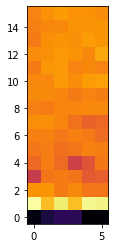

In [39]:
# TEST: Test shorter MFCC
!pip install playsound
from playsound import playsound

idx = 1

# Create path from given filename and target item
path = join(dataset_path, target_list[int(y_orig_train[idx])], 
            filenames_train[idx])

# Create MFCCs
mfccs = calc_mfcc(path)
print("MFCCs:", mfccs)

# Plot MFCC
fig = plt.figure()
plt.imshow(mfccs, cmap='inferno', origin='lower')

# TEST: Play problem sounds
print(target_list[int(y_orig_train[idx])])
#playsound(path) cannot playsound on colab!

In [41]:
# Function: Create MFCCs, keeping only ones of desired length
def extract_features(in_files, in_y):
    prob_cnt = 0
    out_x = []
    out_y = []
        
    for index, filename in enumerate(in_files):
    
        # Create path from given filename and target item
        path = join(dataset_path, target_list[int(in_y[index])], 
                    filename)
        
        # Check to make sure we're reading a .wav file
        if not path.endswith('.wav'):
            continue

        # Create MFCCs
        mfccs = calc_mfcc(path)

        # Only keep MFCCs with given length -> why!?
        if mfccs.shape[1] <= 1000: #==len_mfcc:
            out_x.append(mfccs)
            out_y.append(in_y[index])
        else:
            print('Dropped:', index, mfccs.shape)
            prob_cnt += 1
            
    return out_x, out_y, prob_cnt

In [43]:
# Create train, validation, and test sets
x_train, y_train, prob = extract_features(filenames_train, 
                                          y_orig_train)
#print('Removed percentage:', prob / len(y_orig_train))
x_val, y_val, prob = extract_features(filenames_val, y_orig_val)
#print('Removed percentage:', prob / len(y_orig_val))
x_test, y_test, prob = extract_features(filenames_test, y_orig_test)
#print('Removed percentage:', prob / len(y_orig_test))

In [44]:
# Save features and truth vector (y) sets to disk
np.savez(feature_sets_file, 
         x_train=x_train, 
         y_train=y_train, 
         x_val=x_val, 
         y_val=y_val, 
         x_test=x_test, 
         y_test=y_test)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


ValueError: ignored

In [ ]:
# TEST: Load features
feature_sets = np.load(feature_sets_file)
feature_sets.files

In [ ]:
len(feature_sets['x_train'])

In [ ]:
print(feature_sets['y_val'])

NameError: ignored